In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import KBinsDiscretizer
# from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

# DataFrame Sampling Save

In [11]:
df = pd.read_csv('../Data/Cleaned_data_Inflation_Adjusted_.csv')
df = df[df['BoGender'] != 3]
min_count = df['BoGender'].value_counts().min()
df = df.groupby('BoGender').sample(n=min_count, random_state=42)
df = df.reset_index(drop=True)
df.to_csv("Samples/BoGender.csv", index=False)
print("BoGender : ", df['BoGender'].unique())

print("Saved Samples/BoGender.csv")

df = pd.read_csv('../Data/Cleaned_data_Inflation_Adjusted_.csv')
df = df[~df['BoRace'].isin([4, 7, 8])]
min_count = df['BoRace'].value_counts().min()
df = df.groupby('BoRace').sample(n=min_count, random_state=42)
df = df.reset_index(drop=True)
df.to_csv("Samples/BoRace.csv", index=False)
print("BoRace : ", df['BoRace'].unique())

print("Saved Samples/BoRace.csv")

df = pd.read_csv('../Data/Cleaned_data_Inflation_Adjusted_.csv')
df = df[~df['CoGender'].isin([3, 4])]
min_count = df['CoGender'].value_counts().min()
df = df.groupby('CoGender').sample(n=min_count, random_state=42)
df = df.reset_index(drop=True)
df.to_csv("Samples/CoGender.csv", index=False)
print("CoGender : ", df['CoGender'].unique())

print("Saved Samples/CoGender.csv")

df = pd.read_csv('../Data/Cleaned_data_Inflation_Adjusted_.csv')
df = df[~df['CoRace'].isin([4, 7, 8])]
min_count = df['CoRace'].value_counts().min()
df = df.groupby('CoRace').sample(n=min_count, random_state=42)
df = df.reset_index(drop=True)
df.to_csv("Samples/CoRace.csv", index=False)
print("CoRace : ", df['CoRace'].unique())

print("Saved Samples/CoRace.csv")

BoGender :  [1 2]
Saved Samples/BoGender.csv
BoRace :  [1 2 3 5]
Saved Samples/BoRace.csv
CoGender :  [1 2]
Saved Samples/CoGender.csv
CoRace :  [1 2 3 5]
Saved Samples/CoRace.csv


# Train/Test Split

In [20]:
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = np.sum(cm) - np.sum(cm, axis=0) - np.sum(cm, axis=1) + np.diag(cm)
    fp = np.sum(cm, axis=0) - np.diag(cm)
    specificity_per_class = tn / (tn + fp)
    return np.mean(specificity_per_class)


def evaluate_models_on_split(df, target, models, labels, X, y, train_size=0.8, test_size=0.2):
    results_dir = f"{target}_SPLITS"
    os.makedirs(results_dir, exist_ok=True)

    train_percent = int(train_size * 100)
    test_percent = int(test_size * 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    print(f"\n{target} Training/Testing Split: {train_percent}%/{test_percent}%\n")

    results = {}
    conf_matrices = {}

    for name, model in models.items():
        start_time = time.time()

        if name == "XGBoost":
            le = LabelEncoder()
            y_train_enc = le.fit_transform(y_train)
            y_test_enc = le.transform(y_test)
            model.fit(X_train, y_train_enc)
            y_pred = le.inverse_transform(model.predict(X_test))
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='macro', zero_division=1)
        rec = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        spec = specificity_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        elapsed_time = time.time() - start_time

        results[name] = {
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1,
            "Specificity": spec,
            "Total Runtime (s)": elapsed_time,
        }
        conf_matrices[name] = cm

        print(f"Model: {name}\n Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}, Specificity: {spec:.4f}")
        print("Time taken: {:.2f} seconds\n".format(elapsed_time))

    results_df = pd.DataFrame(results).T
    results_file = os.path.join(results_dir, f"results_split_{train_percent}_{test_percent}.csv")
    results_df.to_csv(results_file)
    print(f"Results saved to {results_file}")

    for name, cm in conf_matrices.items():
        cm_file = os.path.join(results_dir, f"conf_matrix_{train_percent}_{test_percent}_{name.replace(' ', '_')}.csv")
        pd.DataFrame(cm).to_csv(cm_file, index=False)
        print(f"Confusion Matrix for {name} saved to {cm_file}")

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    for i, (name, cm) in enumerate(conf_matrices.items()):
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_norm = np.nan_to_num(cm_norm)

        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=axes[i],
                linewidths=0.5, linecolor='black', annot_kws={"size": 10},
                xticklabels=labels, yticklabels=labels)
        axes[i].set_title(f'{target} - Confusion Matrix - {name} ({train_percent}%/{test_percent}%)')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
        axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=45, va='center')

        plt.figure(figsize=(6, 6))
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
                linewidths=0.5, linecolor='black', annot_kws={"size": 10}, 
                xticklabels=labels, yticklabels=labels)
        plt.title(f'{target} - Confusion Matrix - {name} ({train_percent}%/{test_percent}%)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=45, va='center')
        save_path = os.path.join(results_dir, f"{target}_conf_matrix_{name.replace(' ', '_')}.png")
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()

    plt.savefig(os.path.join(results_dir, f"{target}_all_SPLIT.png"))
    plt.tight_layout()
    plt.show()

In [21]:
def cross_val_predict_xgb(model, X, y, cv):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_pred_all = np.zeros_like(y_encoded)

    for train_idx, test_idx in cv.split(X, y_encoded):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

        model.fit(X_train, y_train)
        y_pred_fold = model.predict(X_test)
        y_pred_all[test_idx] = y_pred_fold

    y_pred_final = le.inverse_transform(y_pred_all)
    return y_pred_final


def evaluate_models_on_CV(df, target, models, labels, X, y, num_folds = 10):  
    cv_results_dir = f"{target}_CV"
    os.makedirs(cv_results_dir, exist_ok=True)

    print(f"\n{target} Performing {num_folds}-fold cross-validation\n")
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    results = {}
    conf_matrices = {}

    for name, model in models.items():
        start_time = time.time()

        if name == "XGBoost":
            y_pred = cross_val_predict_xgb(model, X, y, cv=kf)
        else:
            y_pred = cross_val_predict(model, X, y, cv=kf)

        total_runtime = time.time() - start_time
        
        acc = accuracy_score(y, y_pred)
        prec = precision_score(y, y_pred, average='weighted', zero_division=1)
        rec = recall_score(y, y_pred, average='weighted')
        f1 = f1_score(y, y_pred, average='weighted')
        spec = specificity_score(y, y_pred)
        cm = confusion_matrix(y, y_pred)
        
        results[name] = {
            "Accuracy": acc, 
            "Precision": prec, 
            "Recall": rec, 
            "F1-Score": f1,
            "Specificity": spec, 
            "Total Runtime (s)": total_runtime, 
        }
        
        conf_matrices[name] = cm
        
        print(f"Model: {name}\n Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}, Specificity: {spec:.4f}")
        print("Time taken: {:.2f} seconds".format(total_runtime))

    results_df = pd.DataFrame(results).T
    results_file = f"{cv_results_dir}/results_cv_{num_folds}_folds.csv"
    results_df.to_csv(results_file, index=True)
    print(f"Results saved to {results_file}")

    for name, cm in conf_matrices.items():
        cm_file = f"{cv_results_dir}/conf_matrix_cv_{num_folds}_folds_{name.replace(' ', '_')}.csv"
        pd.DataFrame(cm).to_csv(cm_file, index=False)
        print(f"Confusion Matrix for {name} saved to {cm_file}")

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    for i, (name, cm) in enumerate(conf_matrices.items()):
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_norm = np.nan_to_num(cm_norm)

        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=axes[i], 
                    linewidths=0.5, linecolor='black', annot_kws={"size": 10}, 
                    xticklabels=labels, yticklabels=labels)
        axes[i].set_title(f'{target} - Confusion Matrix - {name} ({num_folds}-Folds CV)')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
        axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=45, va='center')

        plt.figure(figsize=(6, 6))
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
                    linewidths=0.5, linecolor='black', annot_kws={"size": 10},
                    xticklabels=labels, yticklabels=labels)
        plt.title(f'{target} - Confusion Matrix - {name} ({num_folds}-Folds CV)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=45, va='center')
        save_path = os.path.join(cv_results_dir, f"{target}_conf_matrix_{name.replace(' ', '_')}.png")
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()

    plt.savefig(os.path.join(cv_results_dir, f"{target}_all_CV.png"))
    plt.tight_layout()
    plt.show()

In [32]:
models = {
    "ZeroR": DummyClassifier(strategy="most_frequent"),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(verbosity=0, use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(verbose=-1, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
}


BoGender Training/Testing Split: 80%/20%

Model: ZeroR
 Accuracy: 0.4993, Precision: 0.7496, Recall: 0.5000, F1-Score: 0.3330, Specificity: 0.5000
Time taken: 0.05 seconds

Model: Random Forest
 Accuracy: 0.7006, Precision: 0.7006, Recall: 0.7006, F1-Score: 0.7006, Specificity: 0.7006
Time taken: 62.34 seconds

Model: Gradient Boosting
 Accuracy: 0.6912, Precision: 0.6914, Recall: 0.6912, F1-Score: 0.6911, Specificity: 0.6912
Time taken: 64.10 seconds

Model: XGBoost
 Accuracy: 0.7199, Precision: 0.7219, Recall: 0.7200, F1-Score: 0.7194, Specificity: 0.7200
Time taken: 0.58 seconds

Model: LightGBM
 Accuracy: 0.7178, Precision: 0.7201, Recall: 0.7179, F1-Score: 0.7171, Specificity: 0.7179
Time taken: 0.65 seconds

Model: CatBoost
 Accuracy: 0.7223, Precision: 0.7241, Recall: 0.7223, F1-Score: 0.7217, Specificity: 0.7223
Time taken: 10.20 seconds

Results saved to BoGender_SPLITS\results_split_80_20.csv
Confusion Matrix for ZeroR saved to BoGender_SPLITS\conf_matrix_80_20_ZeroR.csv
Con

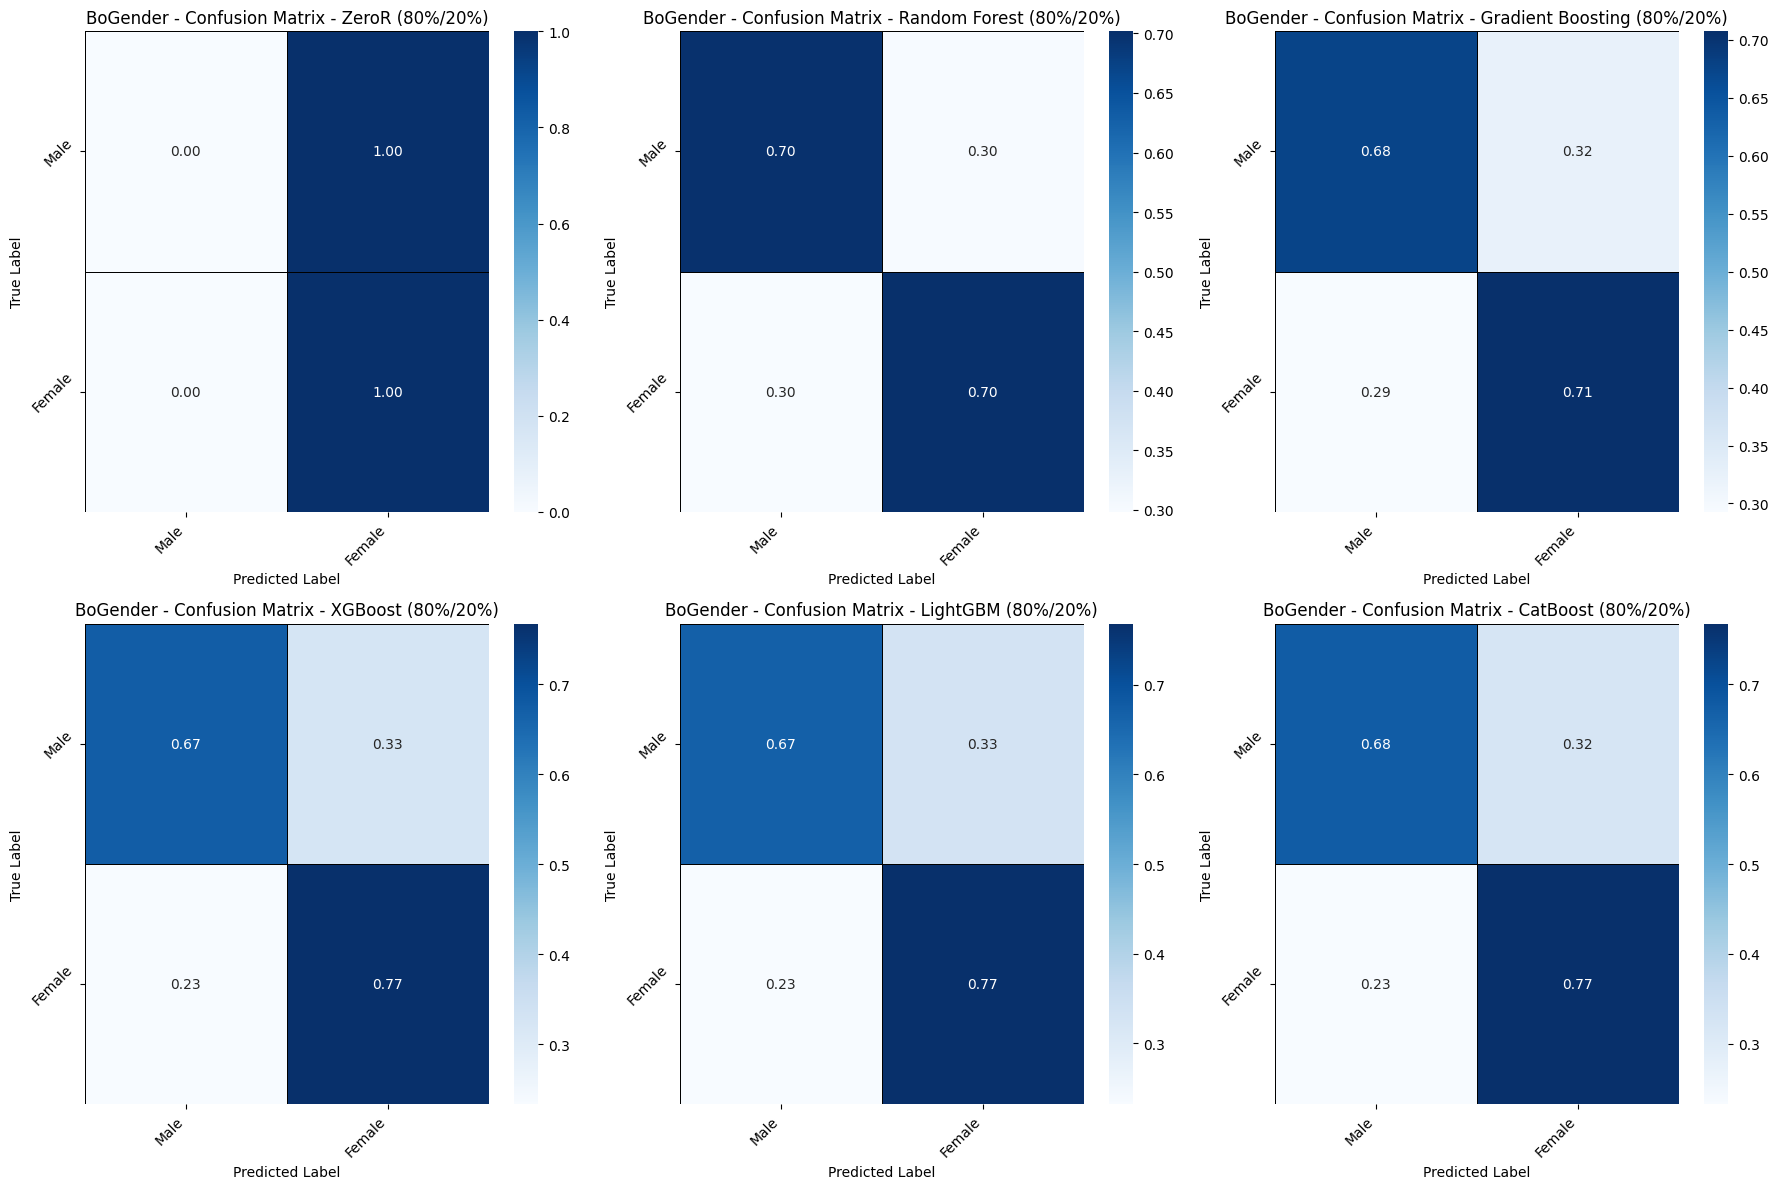


BoGender Performing 10-fold cross-validation

Model: ZeroR
 Accuracy: 0.5000, Precision: 0.5000, Recall: 0.5000, F1-Score: 0.5000, Specificity: 0.5000
Time taken: 0.33 seconds
Model: Random Forest
 Accuracy: 0.6983, Precision: 0.6983, Recall: 0.6983, F1-Score: 0.6983, Specificity: 0.6983
Time taken: 724.71 seconds
Model: Gradient Boosting
 Accuracy: 0.6915, Precision: 0.6916, Recall: 0.6915, F1-Score: 0.6914, Specificity: 0.6915
Time taken: 972.32 seconds
Model: XGBoost
 Accuracy: 0.7193, Precision: 0.7211, Recall: 0.7193, F1-Score: 0.7187, Specificity: 0.7193
Time taken: 7.36 seconds
Model: LightGBM
 Accuracy: 0.7180, Precision: 0.7199, Recall: 0.7180, F1-Score: 0.7173, Specificity: 0.7180
Time taken: 10.94 seconds
Model: CatBoost
 Accuracy: 0.7226, Precision: 0.7244, Recall: 0.7226, F1-Score: 0.7221, Specificity: 0.7226
Time taken: 201.55 seconds
Results saved to BoGender_CV/results_cv_10_folds.csv
Confusion Matrix for ZeroR saved to BoGender_CV/conf_matrix_cv_10_folds_ZeroR.csv
Con

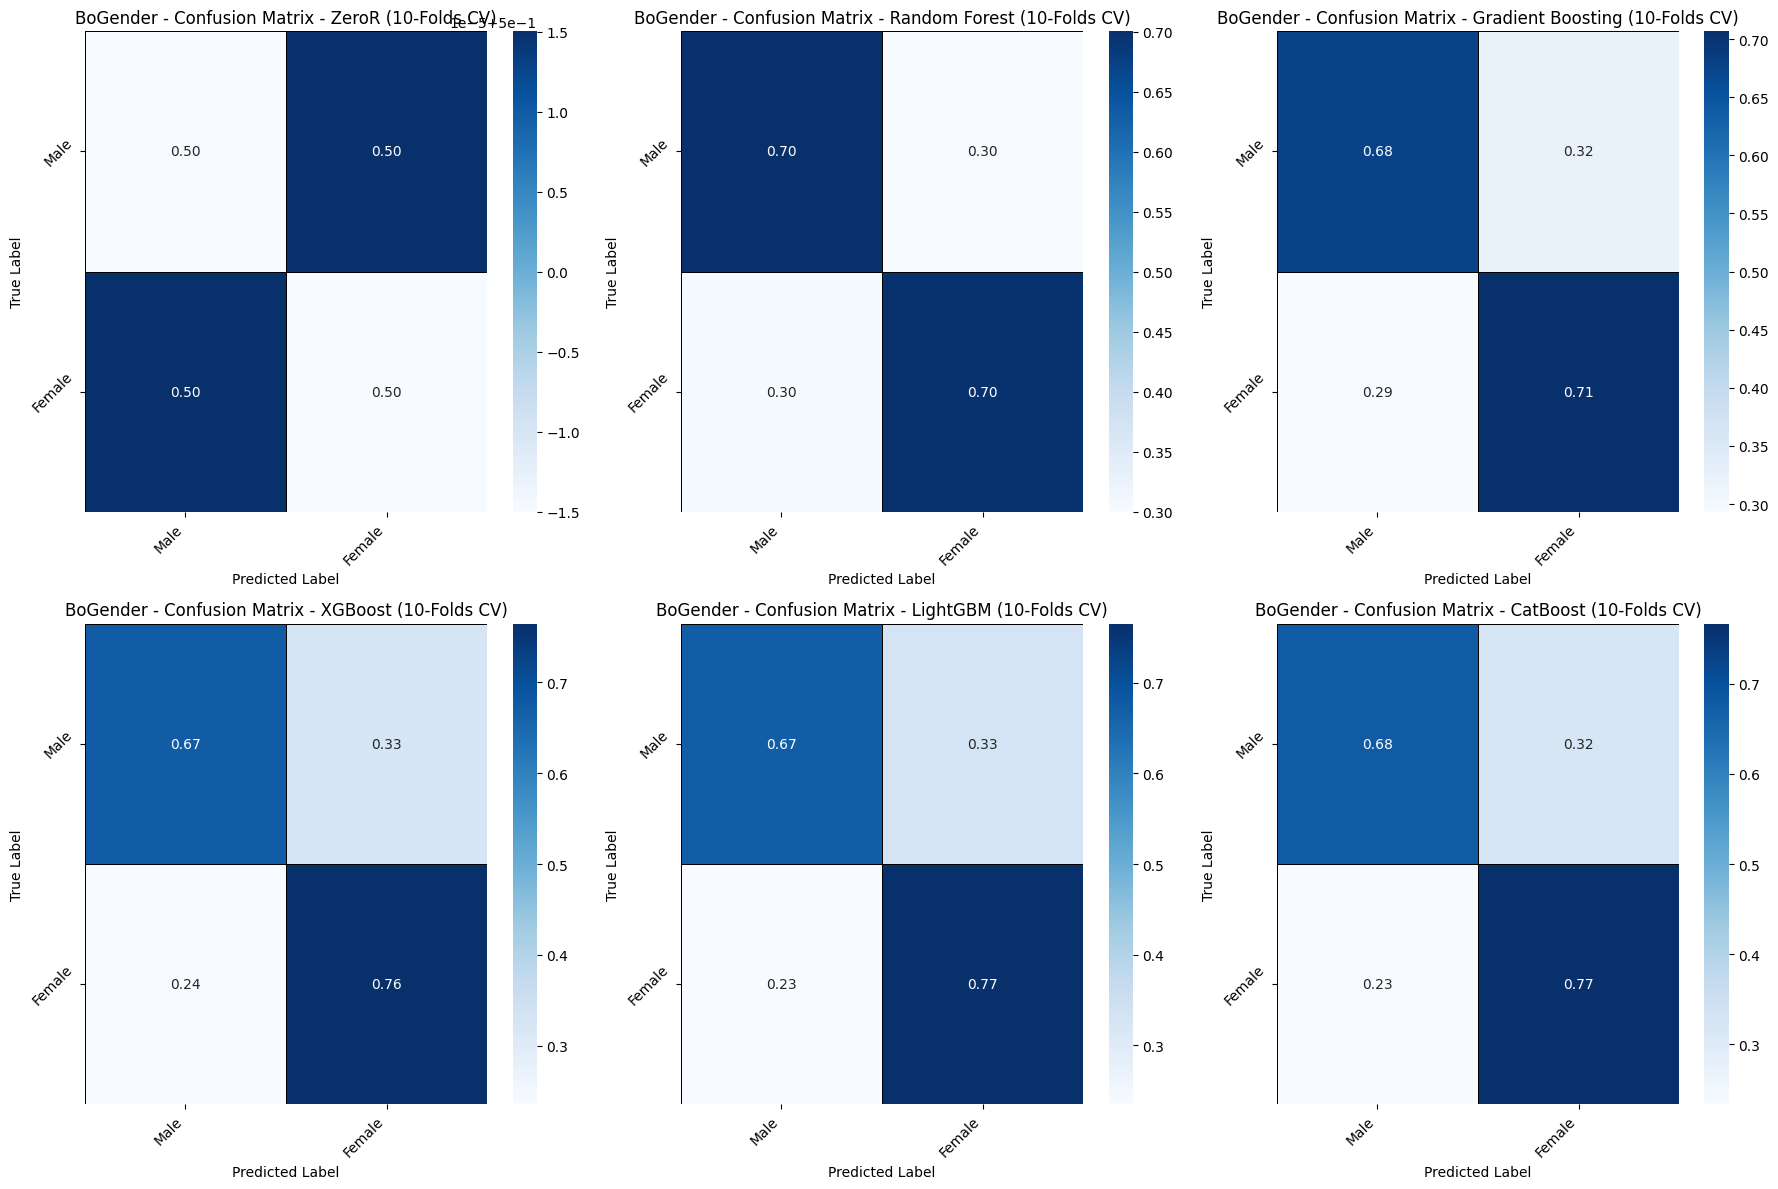

In [23]:
df = pd.read_csv("Samples/BoGender.csv")
X = df.drop(columns=["BoGender", "CoGender"])
y = df["BoGender"]
labels = ["Male", "Female"]

evaluate_models_on_split(df, "BoGender", models, labels, X, y)
evaluate_models_on_CV(df, "BoGender", models, labels, X, y)


BoRace Training/Testing Split: 80%/20%

Model: ZeroR
 Accuracy: 0.2333, Precision: 0.8083, Recall: 0.2500, F1-Score: 0.0946, Specificity: 0.7500
Time taken: 0.01 seconds

Model: Random Forest
 Accuracy: 0.6428, Precision: 0.6534, Recall: 0.6434, F1-Score: 0.6439, Specificity: 0.8811
Time taken: 3.08 seconds

Model: Gradient Boosting
 Accuracy: 0.6385, Precision: 0.6457, Recall: 0.6386, F1-Score: 0.6394, Specificity: 0.8797
Time taken: 16.81 seconds

Model: XGBoost
 Accuracy: 0.6451, Precision: 0.6520, Recall: 0.6453, F1-Score: 0.6460, Specificity: 0.8819
Time taken: 0.63 seconds

Model: LightGBM
 Accuracy: 0.6481, Precision: 0.6559, Recall: 0.6486, F1-Score: 0.6492, Specificity: 0.8829
Time taken: 1.46 seconds

Model: CatBoost
 Accuracy: 0.6395, Precision: 0.6448, Recall: 0.6396, F1-Score: 0.6400, Specificity: 0.8800
Time taken: 6.01 seconds

Results saved to BoRace_SPLITS\results_split_80_20.csv
Confusion Matrix for ZeroR saved to BoRace_SPLITS\conf_matrix_80_20_ZeroR.csv
Confusion M

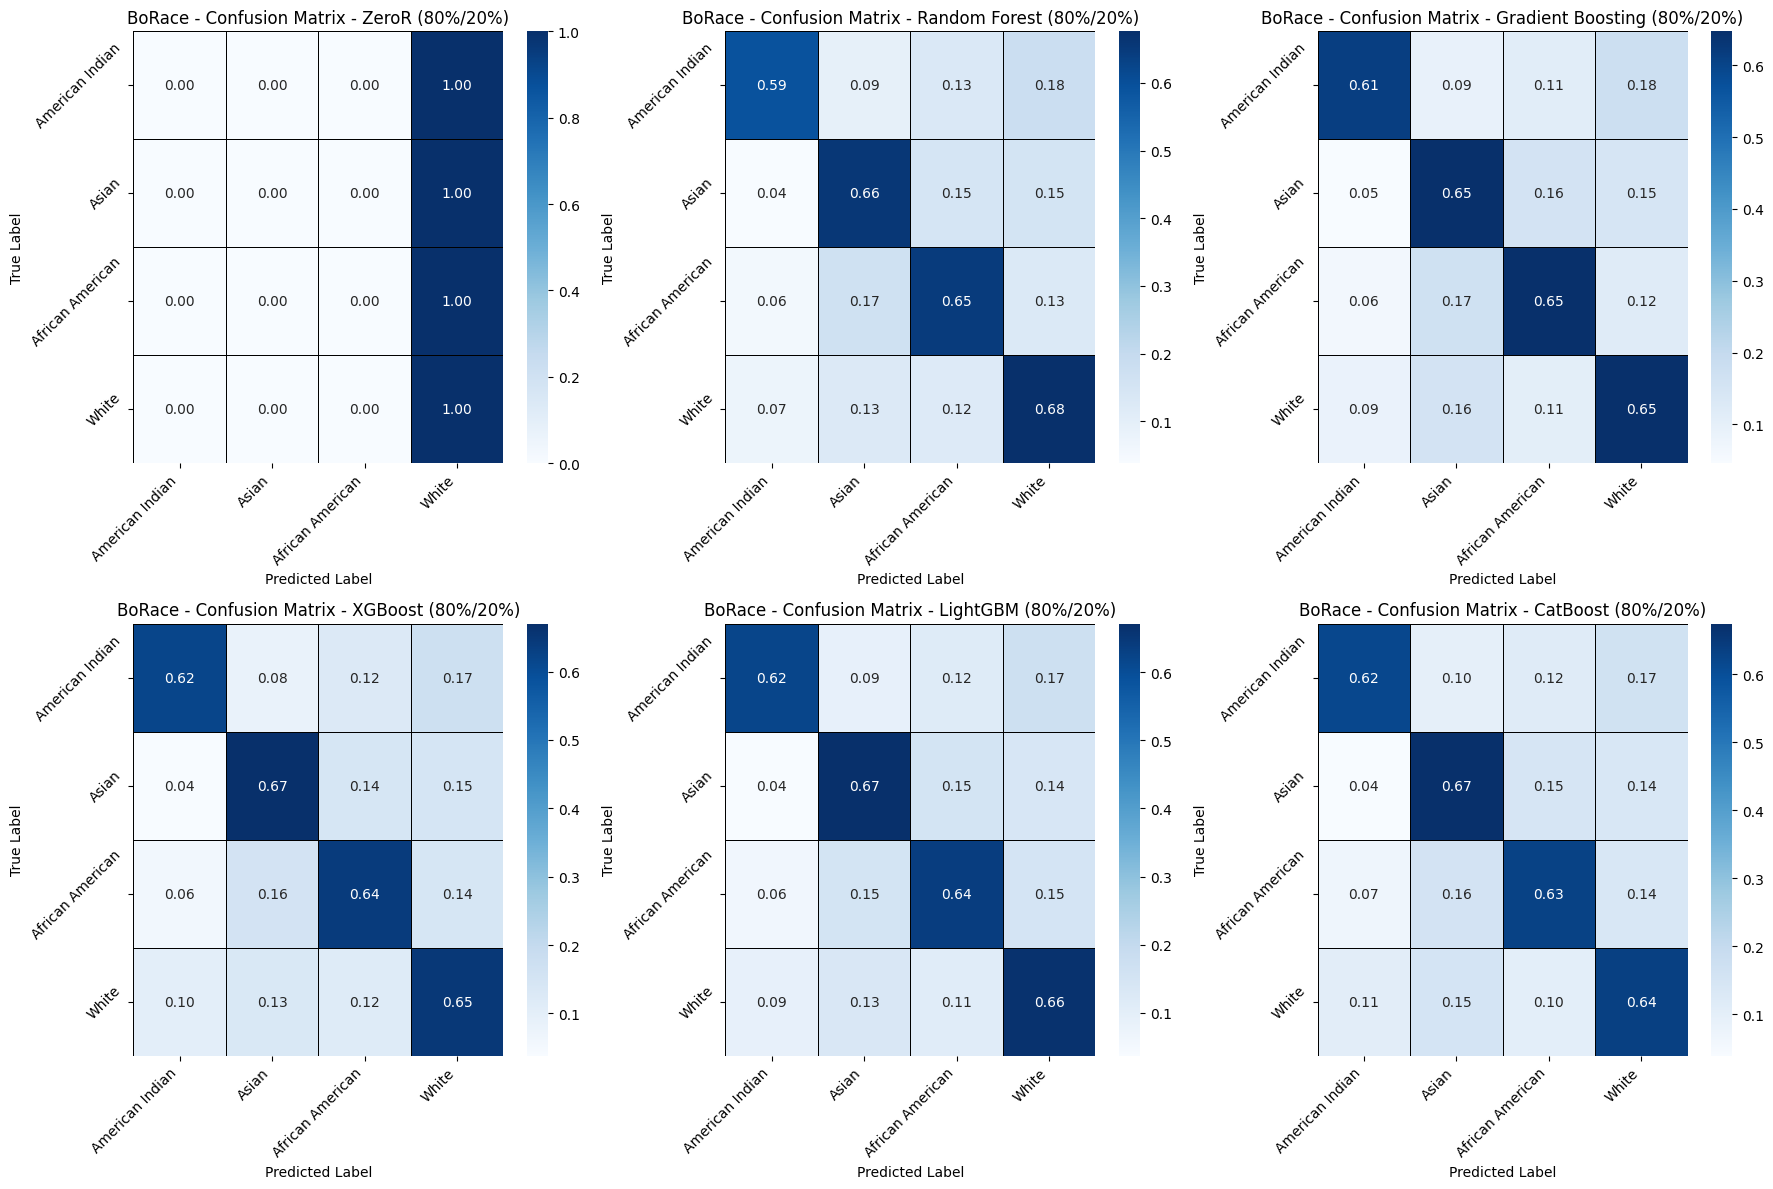


BoRace Performing 10-fold cross-validation

Model: ZeroR
 Accuracy: 0.2499, Precision: 0.6249, Recall: 0.2499, F1-Score: 0.1507, Specificity: 0.7500
Time taken: 0.02 seconds
Model: Random Forest
 Accuracy: 0.6089, Precision: 0.6229, Recall: 0.6089, F1-Score: 0.6089, Specificity: 0.8696
Time taken: 34.11 seconds
Model: Gradient Boosting
 Accuracy: 0.5994, Precision: 0.6099, Recall: 0.5994, F1-Score: 0.5984, Specificity: 0.8665
Time taken: 188.41 seconds
Model: XGBoost
 Accuracy: 0.5693, Precision: 0.5784, Recall: 0.5693, F1-Score: 0.5621, Specificity: 0.8564
Time taken: 6.17 seconds
Model: LightGBM
 Accuracy: 0.5797, Precision: 0.5906, Recall: 0.5797, F1-Score: 0.5734, Specificity: 0.8599
Time taken: 14.46 seconds
Model: CatBoost
 Accuracy: 0.6067, Precision: 0.6162, Recall: 0.6067, F1-Score: 0.6051, Specificity: 0.8689
Time taken: 61.44 seconds
Results saved to BoRace_CV/results_cv_10_folds.csv
Confusion Matrix for ZeroR saved to BoRace_CV/conf_matrix_cv_10_folds_ZeroR.csv
Confusion M

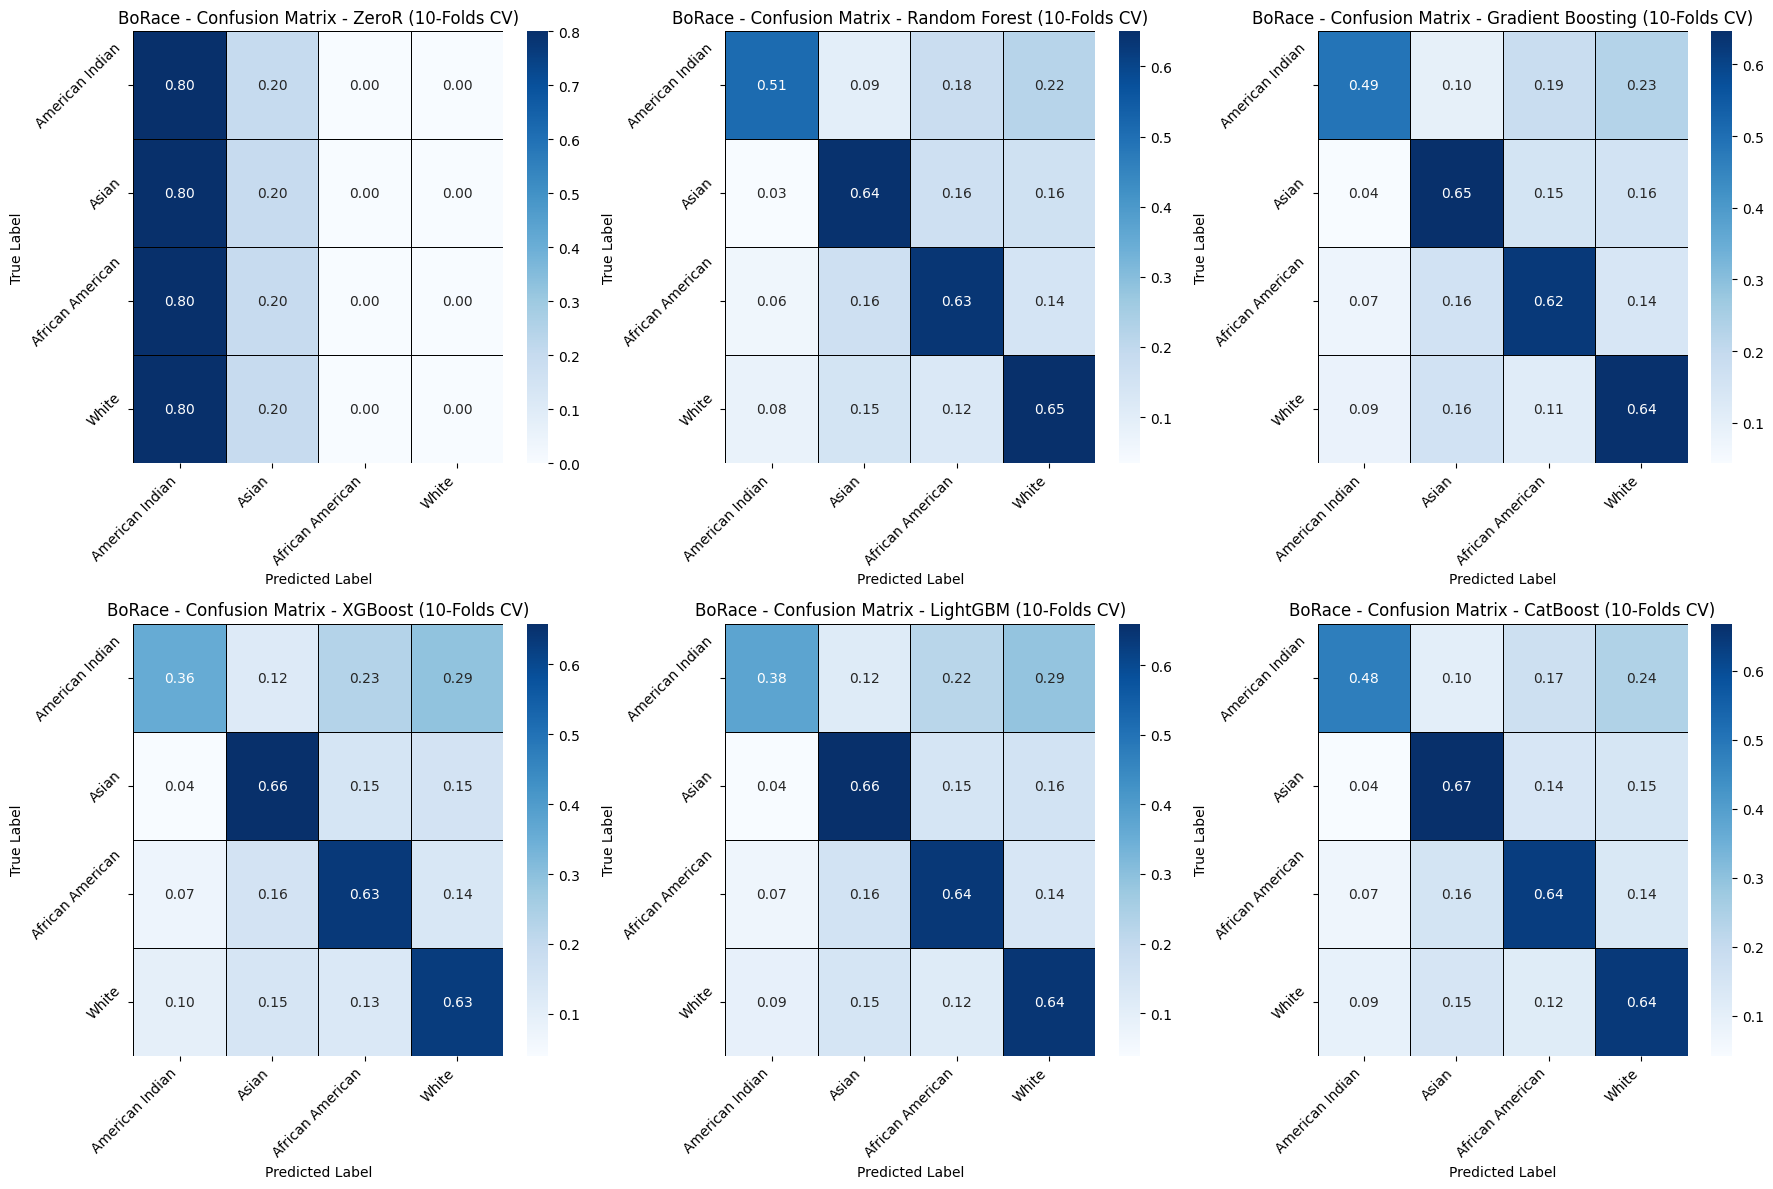

In [24]:
df = pd.read_csv("Samples/BoRace.csv")
X = df.drop(columns=["BoRace", "CoRace"])
y = df["BoRace"]
labels = ["American Indian", "Asian", "African American", "White"]

evaluate_models_on_split(df, "BoRace", models, labels, X, y)
evaluate_models_on_CV(df, "BoRace", models, labels, X, y)


CoGender Training/Testing Split: 80%/20%

Model: ZeroR
 Accuracy: 0.4938, Precision: 0.7469, Recall: 0.5000, F1-Score: 0.3305, Specificity: 0.5000
Time taken: 0.02 seconds

Model: Random Forest
 Accuracy: 0.6766, Precision: 0.6766, Recall: 0.6764, F1-Score: 0.6765, Specificity: 0.6764
Time taken: 20.04 seconds

Model: Gradient Boosting
 Accuracy: 0.7051, Precision: 0.7058, Recall: 0.7054, F1-Score: 0.7050, Specificity: 0.7054
Time taken: 22.89 seconds

Model: XGBoost
 Accuracy: 0.7219, Precision: 0.7225, Recall: 0.7222, F1-Score: 0.7219, Specificity: 0.7222
Time taken: 0.21 seconds

Model: LightGBM
 Accuracy: 0.7246, Precision: 0.7252, Recall: 0.7249, F1-Score: 0.7246, Specificity: 0.7249
Time taken: 0.25 seconds

Model: CatBoost
 Accuracy: 0.7263, Precision: 0.7269, Recall: 0.7266, F1-Score: 0.7263, Specificity: 0.7266
Time taken: 6.51 seconds

Results saved to CoGender_SPLITS\results_split_80_20.csv
Confusion Matrix for ZeroR saved to CoGender_SPLITS\conf_matrix_80_20_ZeroR.csv
Conf

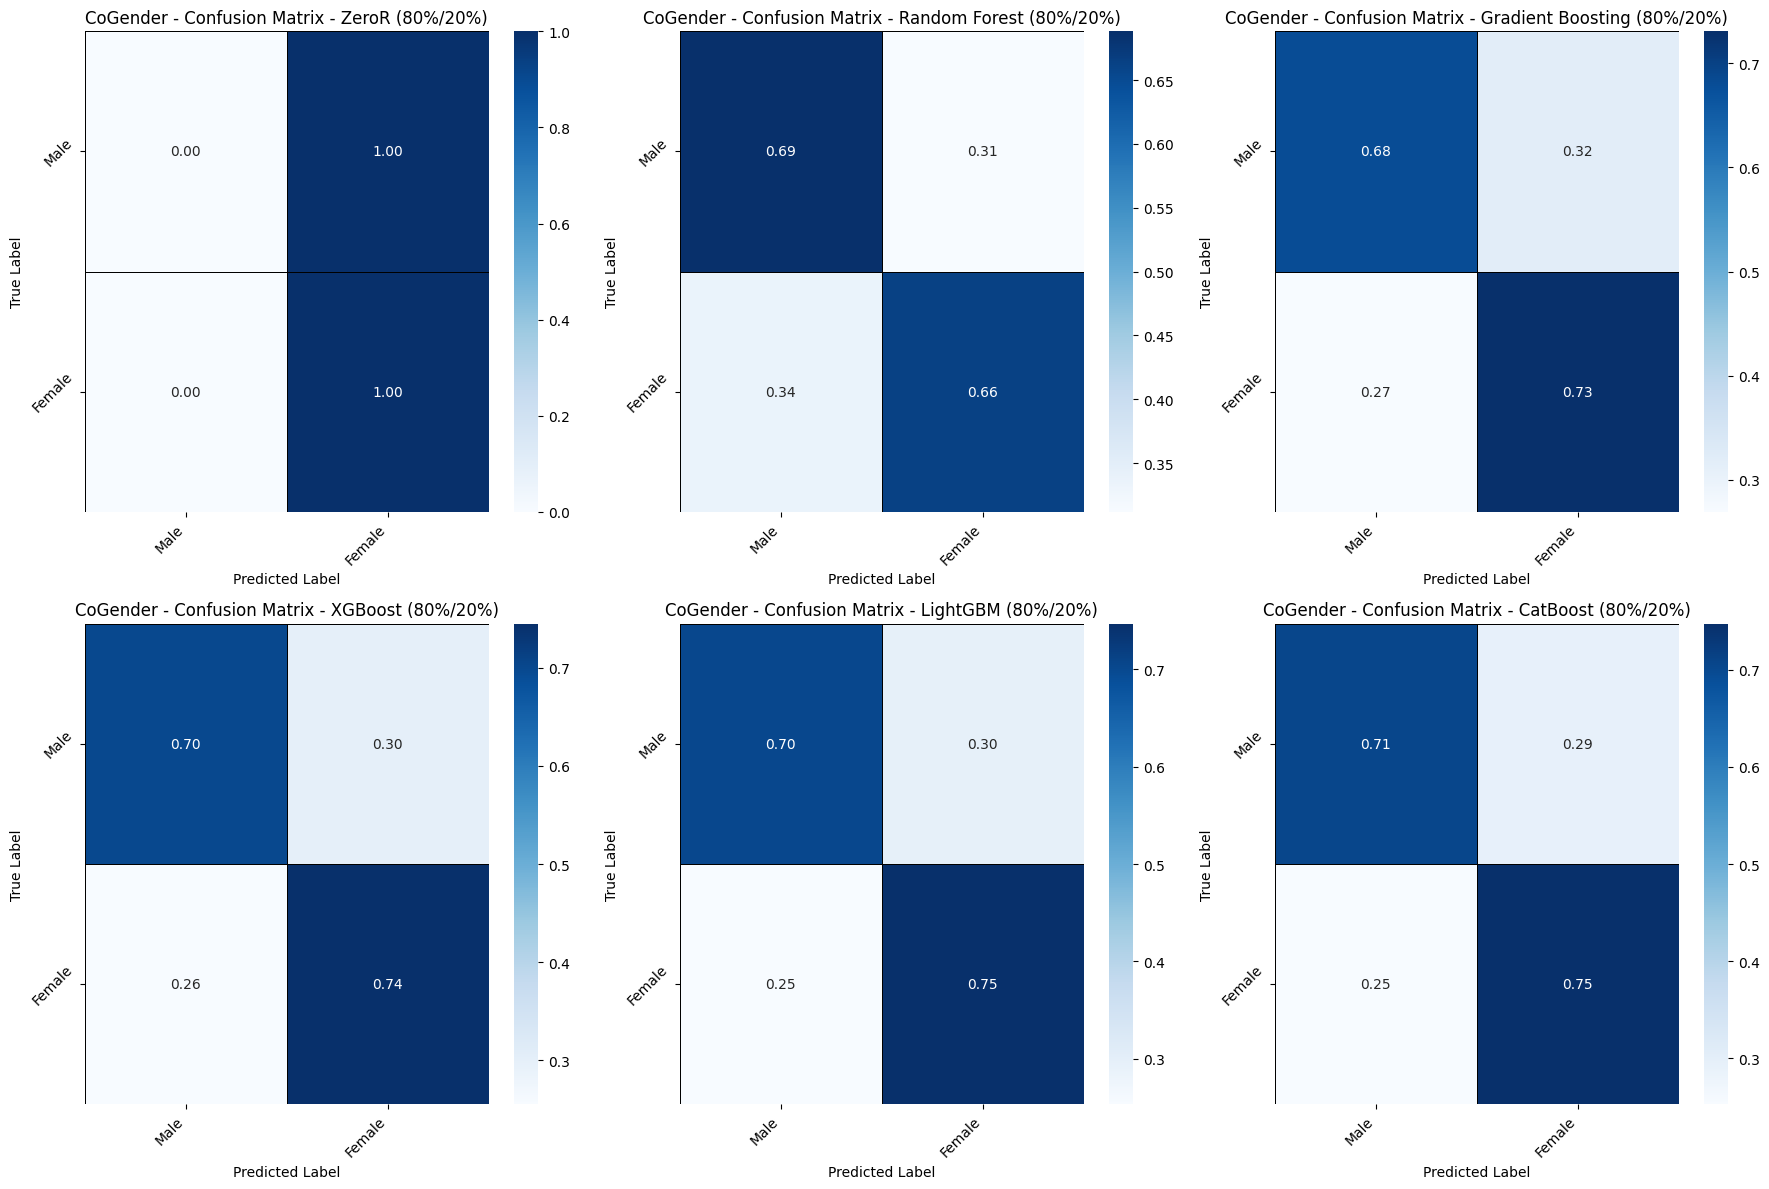


CoGender Performing 10-fold cross-validation

Model: ZeroR
 Accuracy: 0.5000, Precision: 0.5000, Recall: 0.5000, F1-Score: 0.4791, Specificity: 0.5000
Time taken: 0.12 seconds
Model: Random Forest
 Accuracy: 0.3722, Precision: 0.3097, Recall: 0.3722, F1-Score: 0.3160, Specificity: 0.3722
Time taken: 226.43 seconds
Model: Gradient Boosting
 Accuracy: 0.4892, Precision: 0.4861, Recall: 0.4892, F1-Score: 0.4594, Specificity: 0.4892
Time taken: 460.27 seconds
Model: XGBoost
 Accuracy: 0.4115, Precision: 0.3422, Recall: 0.4115, F1-Score: 0.3389, Specificity: 0.4115
Time taken: 21.18 seconds
Model: LightGBM
 Accuracy: 0.4282, Precision: 0.3785, Recall: 0.4282, F1-Score: 0.3631, Specificity: 0.4282
Time taken: 9.54 seconds
Model: CatBoost
 Accuracy: 0.4162, Precision: 0.3506, Recall: 0.4162, F1-Score: 0.3442, Specificity: 0.4162
Time taken: 100.92 seconds
Results saved to CoGender_CV/results_cv_10_folds.csv
Confusion Matrix for ZeroR saved to CoGender_CV/conf_matrix_cv_10_folds_ZeroR.csv
Con

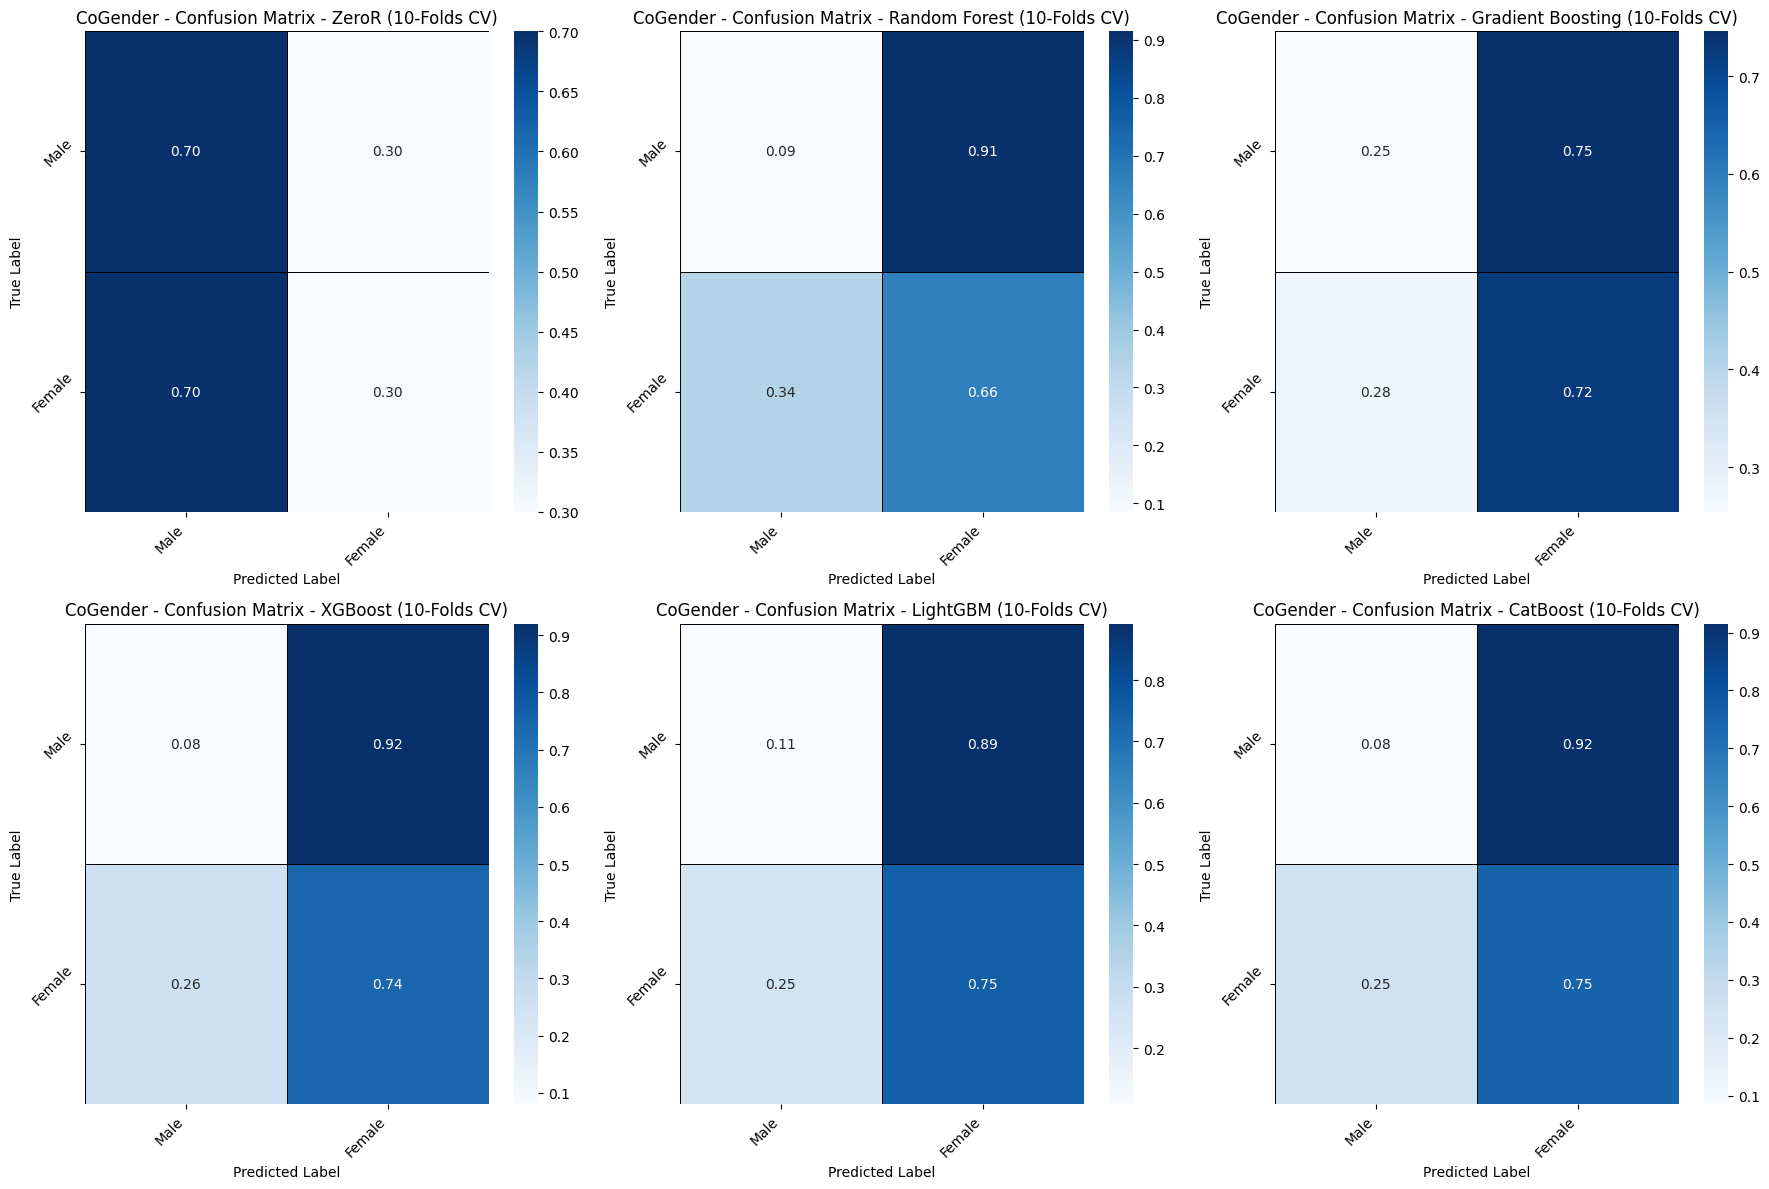

In [33]:
df = pd.read_csv("Samples/CoGender.csv")
X = df.drop(columns=["BoGender", "CoGender"])
y = df["CoGender"]
labels = ["Male", "Female"]


evaluate_models_on_split(df, "CoGender", models, labels, X, y)
evaluate_models_on_CV(df, "CoGender", models, labels, X, y)


CoRace Training/Testing Split: 80%/20%

Model: ZeroR
 Accuracy: 0.2338, Precision: 0.8084, Recall: 0.2500, F1-Score: 0.0947, Specificity: 0.7500
Time taken: 0.01 seconds

Model: Random Forest
 Accuracy: 0.5644, Precision: 0.5710, Recall: 0.5640, F1-Score: 0.5643, Specificity: 0.8551
Time taken: 1.12 seconds

Model: Gradient Boosting
 Accuracy: 0.5726, Precision: 0.5786, Recall: 0.5723, F1-Score: 0.5730, Specificity: 0.8578
Time taken: 6.48 seconds

Model: XGBoost
 Accuracy: 0.5735, Precision: 0.5775, Recall: 0.5726, F1-Score: 0.5735, Specificity: 0.8582
Time taken: 0.57 seconds

Model: LightGBM
 Accuracy: 0.5699, Precision: 0.5781, Recall: 0.5693, F1-Score: 0.5704, Specificity: 0.8570
Time taken: 1.40 seconds

Model: CatBoost
 Accuracy: 0.5662, Precision: 0.5715, Recall: 0.5658, F1-Score: 0.5665, Specificity: 0.8557
Time taken: 5.05 seconds

Results saved to CoRace_SPLITS\results_split_80_20.csv
Confusion Matrix for ZeroR saved to CoRace_SPLITS\conf_matrix_80_20_ZeroR.csv
Confusion Ma

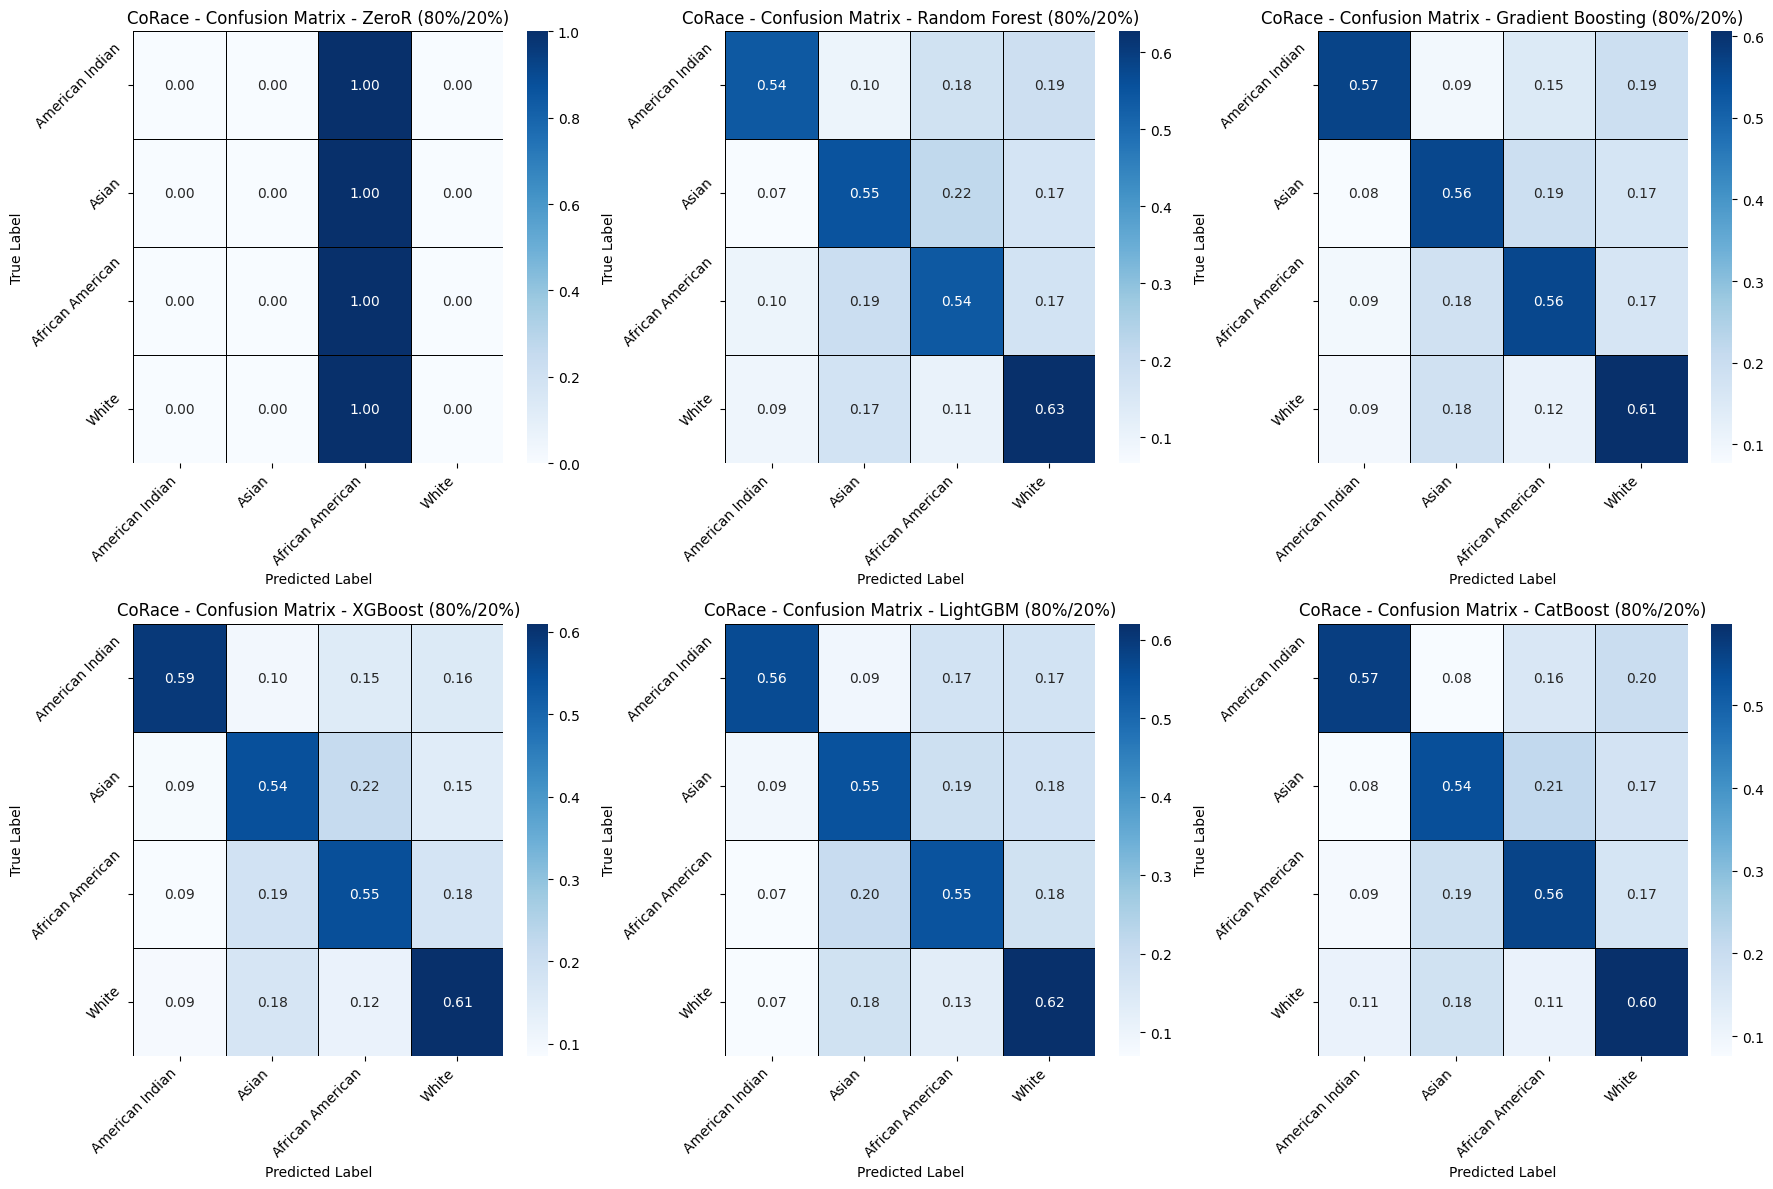


CoRace Performing 10-fold cross-validation

Model: ZeroR
 Accuracy: 0.2489, Precision: 0.2488, Recall: 0.2489, F1-Score: 0.2424, Specificity: 0.7496
Time taken: 0.01 seconds
Model: Random Forest
 Accuracy: 0.5596, Precision: 0.5670, Recall: 0.5596, F1-Score: 0.5575, Specificity: 0.8532
Time taken: 12.09 seconds
Model: Gradient Boosting
 Accuracy: 0.5545, Precision: 0.5599, Recall: 0.5545, F1-Score: 0.5510, Specificity: 0.8515
Time taken: 71.66 seconds
Model: XGBoost
 Accuracy: 0.5252, Precision: 0.5271, Recall: 0.5252, F1-Score: 0.5199, Specificity: 0.8417
Time taken: 5.51 seconds
Model: LightGBM
 Accuracy: 0.5382, Precision: 0.5406, Recall: 0.5382, F1-Score: 0.5334, Specificity: 0.8461
Time taken: 13.64 seconds
Model: CatBoost
 Accuracy: 0.5461, Precision: 0.5491, Recall: 0.5461, F1-Score: 0.5431, Specificity: 0.8487
Time taken: 51.30 seconds
Results saved to CoRace_CV/results_cv_10_folds.csv
Confusion Matrix for ZeroR saved to CoRace_CV/conf_matrix_cv_10_folds_ZeroR.csv
Confusion Ma

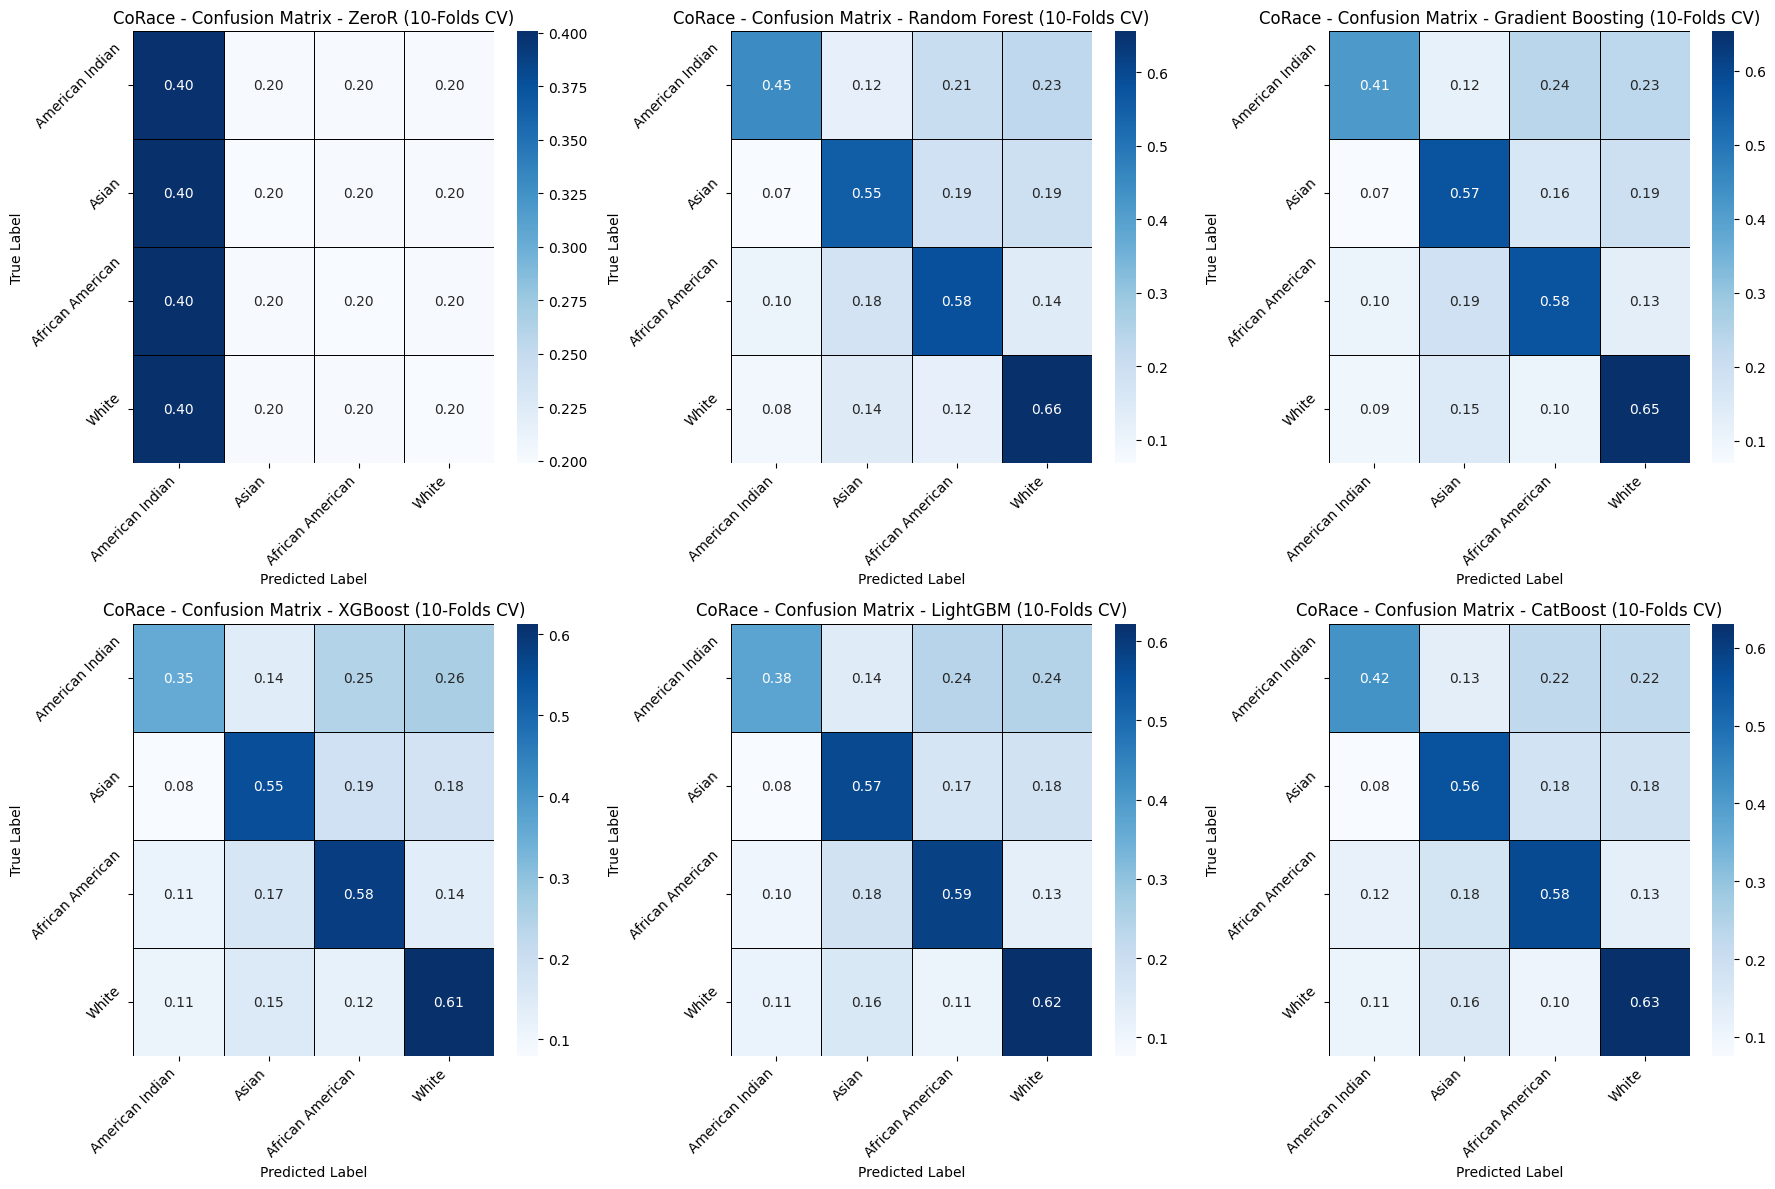

In [34]:
df = pd.read_csv("Samples/CoRace.csv")
X = df.drop(columns=["BoRace", "CoRace"])
y = df["CoRace"]
labels = ["American Indian", "Asian", "African American", "White"]

evaluate_models_on_split(df, "CoRace", models, labels, X, y)
evaluate_models_on_CV(df, "CoRace", models, labels, X, y)